## Определение констант

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns
from typing import List, Tuple, Dict

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostRegressor

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm


sns.set_style("whitegrid")

%matplotlib inline

In [2]:
class Config:
    
    def __init__(self):
        self.root = Path("/home/azureuser/notebooks/lentahack")
        self.color = '#4C18FF'
        self.feature = "UpLift"
        
config = Config()

In [3]:
data_uplift = pd.read_csv(config.root / '20210518_uplift.csv')
data_checks = pd.read_csv(config.root / '20210518_checks.csv')
data_hierarchy = pd.read_csv(config.root / '20210518_hierarchy.csv')
data_offers = pd.read_csv(config.root / '20210521_offers.csv')

In [4]:
data_checks['day'] = pd.to_datetime(data_checks.day, format='%Y%m%d', errors='ignore')
data_offers['start_date'] = pd.to_datetime(data_offers.start_date, format='%Y%m%d', errors='ignore')
data_offers['end_date'] = pd.to_datetime(data_offers.end_date, format='%Y%m%d', errors='ignore')

## Исследование данных

###  Иерархии

In [5]:
data_hierarchy.head()

,sku,hierarchy_level1,hierarchy_level2,hierarchy_level3,hierarchy_level4
0,29285fb39582e5a63c14026198c6ad51,44a7b825383402ed937a15fb8a5bb12a,9a1158154dfa42caddbd0694a4e9bdc8,f50c7035e532c49a0f6993d988e2e843,e9f41ed96e63ca1be6aea099625afe6f
1,f31d0af494b191ef2bc8395db9c8366f,44a7b825383402ed937a15fb8a5bb12a,ad61ab143223efbc24c7d2583be69251,84e8ce7870f0eecd843366582bb95a28,b7fa186535a75c869bfaece622c72689
2,49edad6669ba09dffbf278b76c53cd9d,cc9284597026dcc021735c0970ca0c93,1c383cd30b7c298ab50293adfecb7b18,2a3d6d6cc4b5e77238c1fc1bb6cdd681,7e0e0c1fe174b2d2efbf5ae0e2bc3ee9
3,c5c632eb0f93a233ef6db2620a464ea0,44a7b825383402ed937a15fb8a5bb12a,d82c8d1619ad8176d665453cfb2e55f0,b27d5296bede63b1493a5d321d4e8092,ec2acf8ebfdb679d5fc87caadd98fb58
4,9d0c7880f16c7748e1e992b28655c67f,cc9284597026dcc021735c0970ca0c93,6ea9ab1baa0efb9e19094440c317e21b,379a7ba015d8bf1c70b8add2c287c6fa,5aec2478fac4d1ee912c794c343d036c


In [6]:
data_hierarchy.shape

(80406, 5)

In [56]:
def get_len_unique(df, column: str) -> int:
    return len(np.unique(df[column]))

print(f"Уникальных товаров: {get_len_unique(data_hierarchy, 'sku')}")
print(f"Уникальных категорий иерархий1: {get_len_unique(data_hierarchy, 'hierarchy_level1')}")
print(f"Уникальных категорий иерархий2: {get_len_unique(data_hierarchy, 'hierarchy_level2')}")
print(f"Уникальных категорий иерархий3: {get_len_unique(data_hierarchy, 'hierarchy_level3')}")
print(f"Уникальных категорий иерархий4: {get_len_unique(data_hierarchy, 'hierarchy_level4')}")

Уникальных товаров: 80406
Уникальных категорий иерархий1: 2
Уникальных категорий иерархий2: 65
Уникальных категорий иерархий3: 412
Уникальных категорий иерархий4: 2119


In [46]:
# def show_counts(df: pd.DataFrame, columns: List[str], d: int = 0.1):
#     len_c = len(columns)
#     f, axes = plt.subplots(1, 1, sharey=True, figsize=(15, 8 * len_c))
#     for i, column in enumerate(columns):
#         uniques = np.unique(df[column], return_counts=True)
#         counts = sorted(uniques[1], reverse=True)
        
#         axes[i].plot(range(len(counts)), counts)
#         axes[i].set_title(f"dependence column: {column}")
        
#         min_c = min(counts)
#         max_c = max(counts)
#         axes[i].set_ylim(min_c * (1 - d), max_c * (1 + d))
        
# show_counts(
#     df=data_hierarchy, 
#     columns=["hierarchy_level1", "hierarchy_level2", "hierarchy_level3", "hierarchy_level4"]
# )

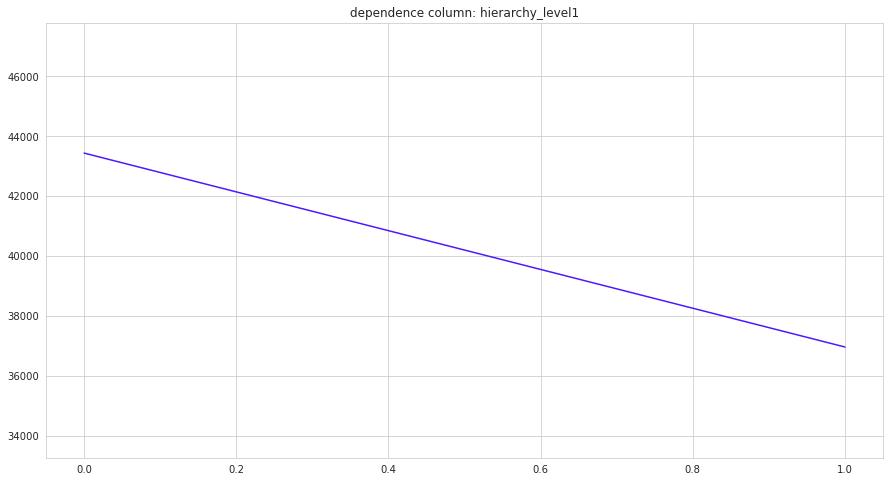

In [7]:
def show_count(df: pd.DataFrame, column: str, d: int = 0.1):
    f, ax = plt.subplots(1, 1, sharey=True, figsize=(15, 8))
    
    uniques = np.unique(df[column], return_counts=True)
    counts = sorted(uniques[1], reverse=True)

    ax.plot(range(len(counts)), counts, color=config.color)
    ax.set_title(f"dependence column: {column}")

    min_c = min(counts)
    max_c = max(counts)
    ax.set_ylim(min_c * (1 - d), max_c * (1 + d))

show_count(data_hierarchy, "hierarchy_level1")

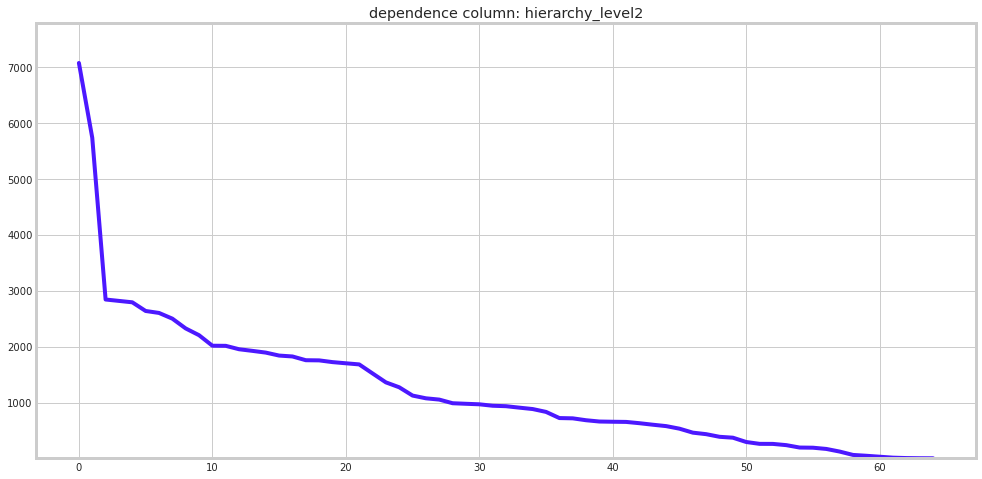

In [226]:
show_count(data_hierarchy, "hierarchy_level2")

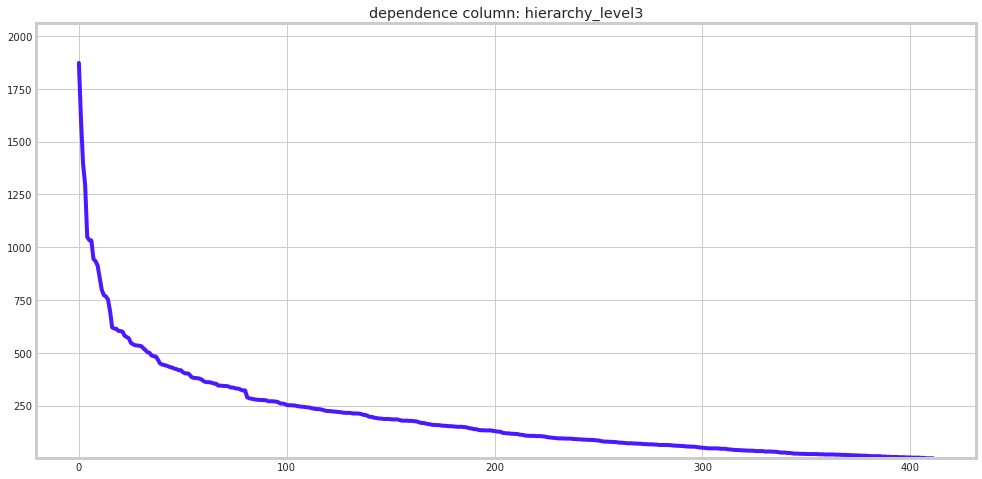

In [227]:
show_count(data_hierarchy, "hierarchy_level3")

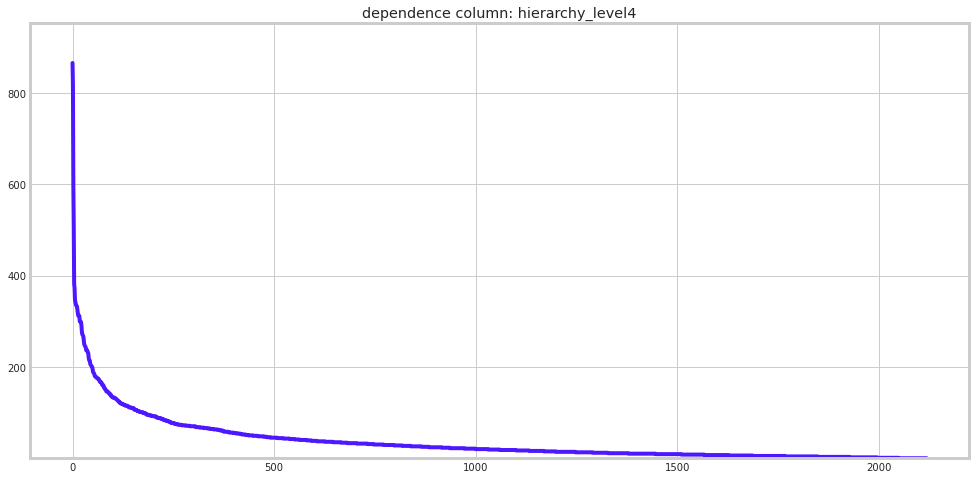

In [228]:
show_count(data_hierarchy, "hierarchy_level4")

### Чеки

In [8]:
data_checks.head()

,client_id,day,shop_id,check_id,time,sku,promo_id,check_pos,num_sales,supplier_price,selling_price,region_name
0,d9da50b77962ad6401d0527db5b65b04,2019-12-30,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,b17c870027bb4a22e3aedb971bc00def,b3deb0286313f0b888c0eac49580cc23,1,5.0,133.40,249.45,152f1b77a32508570e2745daf9ce7aec
1,d9da50b77962ad6401d0527db5b65b04,2019-12-30,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,b9ef00e971d0fb459a765708efba70c0,680a96609351230ed00e1d1090371cbc,2,1.0,96.77,118.99,152f1b77a32508570e2745daf9ce7aec
2,d9da50b77962ad6401d0527db5b65b04,2019-12-30,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,b75147feae4cf8ec07fb5f2cef855def,7215ee9c7d9dc229d2921a40e899ec5f,5,2.0,2.34,7.58,152f1b77a32508570e2745daf9ce7aec
3,d9da50b77962ad6401d0527db5b65b04,2019-12-30,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,b25e0d42165d246d23cbf4d3efcdf583,7215ee9c7d9dc229d2921a40e899ec5f,4,1.0,23.59,39.99,152f1b77a32508570e2745daf9ce7aec
4,d9da50b77962ad6401d0527db5b65b04,2019-12-30,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,a537d2eef30d47f9b11d655421ca93fb,05c93d4fa9bdbe70b5d2204ce9548ca9,3,1.0,24.02,39.99,152f1b77a32508570e2745daf9ce7aec


In [9]:
data_checks.shape

(21479259, 12)

In [11]:
def my_describe(df: pd.DataFrame):
    desc = df.describe()
    for column in desc.columns:
        desc[column] = desc[column].apply(lambda x: f"{x:.2f}")
        
    print(desc)
    
my_describe(data_checks)

         check_pos    num_sales supplier_price selling_price
count  21479259.00  21479259.00    21479259.00   21479259.00
mean         12.01         1.48          84.24        127.56
std          12.01         1.93         149.68        217.60
min           1.00         0.00           0.00          0.00
25%           4.00         1.00          25.49         42.49
50%           8.00         1.00          48.41         77.89
75%          16.00         1.56          95.98        145.99
max         292.00      2009.00       44175.59      58363.44


In [85]:
print(f"Уникальных клиентов: {get_len_unique(data_checks, 'client_id')}")
print(f"Уникальных магазинов: {get_len_unique(data_checks, 'shop_id')}")
print(f"Уникальных чеков: {get_len_unique(data_checks, 'check_id')}")
print(f"Уникальных промоакций: {get_len_unique(data_checks, 'promo_id')}")
print(f"Уникальных регион: {get_len_unique(data_checks, 'region_name')}")

Уникальных клиентов: 100775
Уникальных магазинов: 111
Уникальных чеков: 1866548
Уникальных промоакций: 176939
Уникальных регион: 2


### Изучение зависимости uplift

In [94]:
dataset = data_uplift.join(data_offers.set_index('Offer_ID'), on='Offer_ID')
dataset.head()

,Offer_ID,UpLift,Promo_type,sku,start_date,end_date,train_test_group
0,241,1.743427,Biweekly,ec155b6d970114030333664ad0a9d966,20200416,20200429,train
0,241,1.743427,Biweekly,67b703cefd7a948e0d58879ca1d0bf9b,20200416,20200429,train
0,241,1.743427,Biweekly,26519a5ce77a259252a1c9af08e30ce7,20200416,20200429,train
0,241,1.743427,Biweekly,55d15801290453db237f3107a1534b75,20200416,20200429,train
1,70,16.870948,Biweekly,5c1ae1c6d2a42b332453146940525375,20200305,20200318,train


In [99]:
for prom_val in list(np.unique(dataset.Promo_type)):
    
    mean_uplift = np.mean(dataset[dataset.Promo_type == prom_val].UpLift)
    print(f"{prom_val}: {mean_uplift}")


Billboards: 3.620009684411095
Biweekly: 5.561029421226945
Facades: 2.6307493614513673
Seasonal: 3.708450486890668


In [98]:
for prom_val in list(np.unique([m[4:6] for m in dataset.start_date])):
    
    mean_uplift = np.mean(dataset[dataset.Promo_type == prom_val].UpLift)
    print(f"{prom_val}: {mean_uplift}")

['Billboards', 'Biweekly', 'Facades', 'Seasonal']

### Проверка на nan

In [106]:
print(np.sum(data_uplift.isna()))
print(np.sum(data_offers.isna()))
print(np.sum(data_hierarchy.isna()))
print(np.sum(data_checks.isna()))

Offer_ID    0
UpLift      0
dtype: int64
Promo_type          0
Offer_ID            0
sku                 0
start_date          0
end_date            0
train_test_group    0
dtype: int64
sku                 0
hierarchy_level1    0
hierarchy_level2    0
hierarchy_level3    0
hierarchy_level4    0
dtype: int64
client_id         0
day               0
shop_id           0
check_id          0
time              0
sku               0
promo_id          0
check_pos         0
num_sales         0
supplier_price    0
selling_price     0
region_name       0
dtype: int64


### Чистка данных

In [18]:
data_checks = data_checks[data_checks.supplier_price > 2]
data_checks = data_checks[data_checks.selling_price > 2]

## Генерация фичей

In [19]:
ohe = OneHotEncoder()

### Эмбедддинги
Варианты:
- PCA
- TSNE
- Нейронная сеть

#### Информация о типе товара

In [21]:
data_hierarchy.head()

,sku,hierarchy_level1,hierarchy_level2,hierarchy_level3,hierarchy_level4
0,29285fb39582e5a63c14026198c6ad51,44a7b825383402ed937a15fb8a5bb12a,9a1158154dfa42caddbd0694a4e9bdc8,f50c7035e532c49a0f6993d988e2e843,e9f41ed96e63ca1be6aea099625afe6f
1,f31d0af494b191ef2bc8395db9c8366f,44a7b825383402ed937a15fb8a5bb12a,ad61ab143223efbc24c7d2583be69251,84e8ce7870f0eecd843366582bb95a28,b7fa186535a75c869bfaece622c72689
2,49edad6669ba09dffbf278b76c53cd9d,cc9284597026dcc021735c0970ca0c93,1c383cd30b7c298ab50293adfecb7b18,2a3d6d6cc4b5e77238c1fc1bb6cdd681,7e0e0c1fe174b2d2efbf5ae0e2bc3ee9
3,c5c632eb0f93a233ef6db2620a464ea0,44a7b825383402ed937a15fb8a5bb12a,d82c8d1619ad8176d665453cfb2e55f0,b27d5296bede63b1493a5d321d4e8092,ec2acf8ebfdb679d5fc87caadd98fb58
4,9d0c7880f16c7748e1e992b28655c67f,cc9284597026dcc021735c0970ca0c93,6ea9ab1baa0efb9e19094440c317e21b,379a7ba015d8bf1c70b8add2c287c6fa,5aec2478fac4d1ee912c794c343d036c


In [22]:
# columns = ["hierarchy_level1", "hierarchy_level2", "hierarchy_level3", "hierarchy_level4"]
# drop_columns = ["sku"]
columns = ["hierarchy_level1", "hierarchy_level2", "hierarchy_level3", "hierarchy_level4"]
drop_columns = ["sku"]
dh = pd.get_dummies(data_hierarchy, prefix=[f"l{i + 1}" for i in range(len(columns))], columns=columns)
dh.shape

(80406, 2599)

In [23]:
dh_data = dh.drop(columns=drop_columns)
dh_data.shape

(80406, 2598)

In [24]:
limit=290

In [25]:
pca = PCA(limit)

In [26]:
dh_pca = pca.fit_transform(dh_data)

In [27]:
dh_pca.shape

(80406, 290)

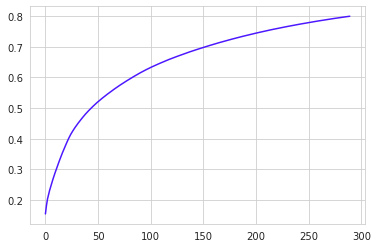

In [28]:
cs = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(len(cs)), cs, color=config.color)

In [29]:
sum(pca.explained_variance_ratio_)

0.7996233490604724

In [30]:
dict_df_h = {f"c_{i}": dh_pca[:, i] for i in range(dh_pca.shape[1])}
print(len(dict_df_h["c_1"]))
dict_df_h["sku"] = data_hierarchy["sku"].to_list()

df_h = pd.DataFrame.from_dict(dict_df_h).set_index("sku")
df_h.shape

80406


(80406, 290)

df_h для использования в prices

In [31]:
sku_list = data_offers.sku.tolist()
sub_data_hierarchy = data_hierarchy[data_hierarchy.sku.apply(lambda x: x in sku_list)]
sub_data_hierarchy.shape

(4200, 5)

In [32]:
columns = ["hierarchy_level1", "hierarchy_level2", "hierarchy_level3", "hierarchy_level4"]
drop_columns = ["sku"]
dh = pd.get_dummies(sub_data_hierarchy, prefix=[f"l{i + 1}" for i in range(len(columns))], columns=columns)
dh.shape

(4200, 648)

In [33]:
dh_data = dh.drop(columns=drop_columns)
dh_data.shape

(4200, 647)

In [34]:
pca = PCA(40)

In [35]:
dh_pca = pca.fit_transform(dh_data)

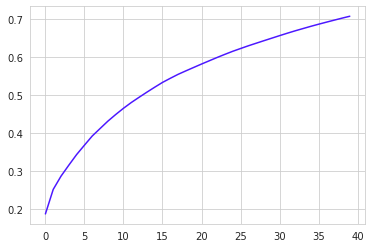

In [36]:
cs = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(len(cs)), cs, color=config.color)

In [37]:
sum(pca.explained_variance_ratio_)

0.707105989530145

In [38]:
dict_df_h = {f"c_{i}": dh_pca[:, i] for i in range(dh_pca.shape[1])}
print(len(dict_df_h["c_1"]))
dict_df_h["sku"] = sub_data_hierarchy["sku"].to_list()

df_h_offer = pd.DataFrame.from_dict(dict_df_h).set_index("sku")
df_h_offer.shape

4200


(4200, 40)

#### Информация по чекам

In [40]:
print(data_checks.shape)
data_checks.head()

(21080516, 12)


,client_id,day,shop_id,check_id,time,sku,promo_id,check_pos,num_sales,supplier_price,selling_price,region_name
0,d9da50b77962ad6401d0527db5b65b04,2019-12-30,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,b17c870027bb4a22e3aedb971bc00def,b3deb0286313f0b888c0eac49580cc23,1,5.0,133.40,249.45,152f1b77a32508570e2745daf9ce7aec
1,d9da50b77962ad6401d0527db5b65b04,2019-12-30,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,b9ef00e971d0fb459a765708efba70c0,680a96609351230ed00e1d1090371cbc,2,1.0,96.77,118.99,152f1b77a32508570e2745daf9ce7aec
2,d9da50b77962ad6401d0527db5b65b04,2019-12-30,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,b75147feae4cf8ec07fb5f2cef855def,7215ee9c7d9dc229d2921a40e899ec5f,5,2.0,2.34,7.58,152f1b77a32508570e2745daf9ce7aec
3,d9da50b77962ad6401d0527db5b65b04,2019-12-30,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,b25e0d42165d246d23cbf4d3efcdf583,7215ee9c7d9dc229d2921a40e899ec5f,4,1.0,23.59,39.99,152f1b77a32508570e2745daf9ce7aec
4,d9da50b77962ad6401d0527db5b65b04,2019-12-30,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,a537d2eef30d47f9b11d655421ca93fb,05c93d4fa9bdbe70b5d2204ce9548ca9,3,1.0,24.02,39.99,152f1b77a32508570e2745daf9ce7aec


In [41]:
df_ch = data_checks.copy()

In [42]:
df_ch['in_promo'] = df_ch.promo_id.apply(lambda x: 0 if x == 10881653 else 1)

In [43]:
#значение наценок по неделям
df_ch['one_thing_price'] = df_ch['selling_price'] / df_ch['num_sales']
df_ch['one_thing_suppplier_price'] = df_ch['supplier_price'] / df_ch['num_sales']
df_ch['one_thing_suppplier_price'] = df_ch['one_thing_suppplier_price'].apply(lambda x: x if x > 0.0001 else 1)
df_ch['ratio'] = df_ch['one_thing_price'] / df_ch['one_thing_suppplier_price'] # наценка
df_ch['week'] = df_ch.day.dt.isocalendar().week
df_ch[['week', 'ratio', 'sku']].groupby(['week', 'sku']).mean()

#значение продаж по неделям
df_ch['week'] = df_ch.day.dt.isocalendar().week
ratio_with_weeks = df_ch[['week', 'ratio', 'sku']].groupby(['week', 'sku']).mean()
ratio_with_weeks.columns = ['ratio_by_week']

df_ch = ratio_with_weeks.join(df_ch.set_index(['sku', 'week']), on=['sku', 'week']).reset_index()

In [44]:
#значение продаж по месяцам
df_ch['month'] = df_ch.day.dt.month
ratio_with_month = df_ch[['month', 'ratio', 'sku']].groupby(['month', 'sku']).mean()
ratio_with_month.columns = ['ratio_by_month']
df_ch = ratio_with_month.join(df_ch.set_index(['sku', 'month']), on=['sku', 'month']).reset_index()
df_ch.head()

,month,sku,ratio_by_month,week,ratio_by_week,client_id,day,shop_id,check_id,time,promo_id,check_pos,num_sales,supplier_price,selling_price,region_name,in_promo,one_thing_price,one_thing_suppplier_price,ratio
0,1,00011c1252f877221e0e0a3ddf21858e,2.664913,1,1.775329,b095f6ca0ce7c2cd841caced4a7ecab3,2020-01-04,7d7c45b9a935cf9d845fc75679a41559,2aa681fe29c147f2973283aacbaedd9b,15:14:46,7215ee9c7d9dc229d2921a40e899ec5f,11,2.0,158.58,456.20,7e35e74e610188414ad24235dd787c78,1,228.10,79.29,2.876781
1,1,00011c1252f877221e0e0a3ddf21858e,2.664913,1,1.775329,914a8e7a41c8de86d410032a3635d2b6,2020-01-02,e960bd3154493f20a5a54c28f5686d4e,0e6c728c5e6cfddcffeaffde3fe4f0ce,12:42:58,91ba94d04db8bdcec4ec3c8337c07e89,5,1.0,81.36,119.99,7e35e74e610188414ad24235dd787c78,1,119.99,81.36,1.474803
2,1,00011c1252f877221e0e0a3ddf21858e,2.664913,2,2.836526,31cda39b8886f153e5691e5b6071dbef,2020-01-07,fee67cadcc3a0bec8e00641884903c45,224fb5caa5fdf13a529731ca2cc6d1f7,16:54:10,7215ee9c7d9dc229d2921a40e899ec5f,1,1.0,80.38,228.00,7e35e74e610188414ad24235dd787c78,1,228.00,80.38,2.836526
3,1,00011c1252f877221e0e0a3ddf21858e,2.664913,3,2.926273,538b0f6adf0807730f80e45efb29ffcb,2020-01-17,335e2d36ca1a5def183273b492a32c63,f6e1a4bd41e46fda88e870a98aee3fdc,19:53:07,7215ee9c7d9dc229d2921a40e899ec5f,2,1.0,77.99,228.05,152f1b77a32508570e2745daf9ce7aec,1,228.05,77.99,2.924093
4,1,00011c1252f877221e0e0a3ddf21858e,2.664913,3,2.926273,2a26993a999fc7f2c1b08402478b579e,2020-01-14,335e2d36ca1a5def183273b492a32c63,20385be8ae13c45c88c96c9217ea5ac4,19:26:00,7215ee9c7d9dc229d2921a40e899ec5f,14,1.0,77.99,228.39,152f1b77a32508570e2745daf9ce7aec,1,228.39,77.99,2.928452


In [45]:
# информация по городам
df_ch['city'] = df_ch.region_name.apply(lambda x: 0 if x == '152f1b77a32508570e2745daf9ce7aec' else 1) 

cities = df_ch[['sku', 'one_thing_price', 'city']].groupby(['sku', 'city']).mean()
cities.columns = ['avg_price_per_city']
df_ch = cities.join(df_ch.set_index(['sku', 'city']), on=['sku', 'city']).reset_index()

In [46]:
prices = df_ch[['sku', 'one_thing_price']].groupby('sku').min()
prices.columns = ['min_price']
prices['max_price'] = df_ch[['sku', 'one_thing_price']].groupby('sku').max()
prices['mean_price'] = df_ch[['sku', 'one_thing_price']].groupby('sku').mean()

df_ch = prices.join(df_ch.set_index('sku'), on='sku').reset_index()

In [47]:
df_ch.shape

(21080516, 25)

In [67]:
cols = ["month", "week", "client_id", "day", "shop_id", "check_id", "time", "region_name", "promo_id", "num_sales", "check_pos", 'supplier_price', 'selling_price']
df_ch_total = df_ch.drop(columns=cols)
df_ch_total.head()

,sku,min_price,max_price,mean_price,city,avg_price_per_city,ratio_by_month,ratio_by_week,in_promo,one_thing_price,one_thing_suppplier_price,ratio
0,00011c1252f877221e0e0a3ddf21858e,99.99,257.49,167.347135,0,169.562973,2.664913,2.926273,1,228.05,77.99,2.924093
1,00011c1252f877221e0e0a3ddf21858e,99.99,257.49,167.347135,0,169.562973,2.664913,2.926273,1,228.39,77.99,2.928452
2,00011c1252f877221e0e0a3ddf21858e,99.99,257.49,167.347135,0,169.562973,2.664913,2.805635,1,227.64,82.96,2.743973
3,00011c1252f877221e0e0a3ddf21858e,99.99,257.49,167.347135,0,169.562973,2.664913,2.741895,1,228.39,78.18,2.921335
4,00011c1252f877221e0e0a3ddf21858e,99.99,257.49,167.347135,0,169.562973,2.664913,2.741895,1,228.39,94.73,2.410957


In [68]:
df_ch_total = df_ch_total.groupby("sku").mean()

In [69]:
df_ch_total.head()

,min_price,max_price,mean_price,city,avg_price_per_city,ratio_by_month,ratio_by_week,in_promo,one_thing_price,one_thing_suppplier_price,ratio
sku,,,,,,,,,,,
00011c1252f877221e0e0a3ddf21858e,99.990000,257.490000,167.347135,0.350877,167.347135,1.893145,1.893145,1.0,167.347135,87.841257,1.893145
000189cbec3b82946747db131d67805a,9.950000,70.890000,50.821231,0.438462,50.821231,1.885732,1.885732,1.0,50.821231,26.956875,1.885732
000273bf6eb4ba9a2ec52c0b5ee564ed,85.597087,248.546967,138.094927,0.333333,138.094927,1.550372,1.550372,1.0,138.094927,89.111643,1.550372
00033dd12618c86f7451b1e18af8bb60,209.620000,349.990000,269.618600,0.660000,269.618600,1.592381,1.592381,1.0,269.618600,169.372700,1.592381
00059f95a35296c81dbcd8a0e0cdfc25,29.990000,99.020000,48.088000,0.300000,48.088000,0.933729,0.933729,1.0,48.088000,51.500500,0.933729


In [49]:
# выручка по месяцам 

df_check_by_date = data_checks[['supplier_price', 'selling_price', 'day']]
df_check_by_date['month'] = data_checks.day.dt.month
del df_check_by_date['day']

df_check_by_date = df_check_by_date.sort_values(by='month')

df_check_by_date['revenue_by_date'] = df_check_by_date['selling_price'] / df_check_by_date['supplier_price'] - 1
df_check_by_date['revenue_by_date'] = df_check_by_date['revenue_by_date'].apply(lambda x: x if x > 0.0001  else 1)

del df_check_by_date['supplier_price']
del df_check_by_date['selling_price']
df_check_by_date['revenue_by_date_lagged'] = df_check_by_date.groupby(['month'])['revenue_by_date'].shift(1)

df_check_by_date = df_check_by_date.dropna()

df_check_by_date['revenue_before_month'] = df_check_by_date['revenue_by_date_lagged'] /  df_check_by_date['revenue_by_date']

<ipython-input-49-d7a3f7edb66b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_check_by_date['month'] = data_checks.day.dt.month


In [50]:
df_check = data_checks[['supplier_price', 'selling_price', 'promo_id']]
df_check['revenue_by_promo_id'] = df_check['selling_price'] - df_check['supplier_price']
df_check = df_check[['revenue_by_promo_id', 'promo_id']].groupby('promo_id').sum()

<ipython-input-50-9f6bb17b526d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_check['revenue_by_promo_id'] = df_check['selling_price'] - df_check['supplier_price']


In [51]:
d_check = data_checks.copy()

In [52]:
d_check = d_check.join(df_check, on="promo_id")[["sku", "revenue_by_promo_id"]]
d_check.head()

,sku,revenue_by_promo_id
0,b17c870027bb4a22e3aedb971bc00def,5.469518e+05
1,b9ef00e971d0fb459a765708efba70c0,2.152360e+04
2,b75147feae4cf8ec07fb5f2cef855def,5.232737e+08
3,b25e0d42165d246d23cbf4d3efcdf583,5.232737e+08
4,a537d2eef30d47f9b11d655421ca93fb,3.035650e+03


In [53]:
d_check = d_check.join(df_check_by_date).drop(columns=["month", "revenue_by_date", "revenue_by_date_lagged"]); d_check.head()

,sku,revenue_by_promo_id,revenue_before_month
0,b17c870027bb4a22e3aedb971bc00def,5.469518e+05,0.320819
1,b9ef00e971d0fb459a765708efba70c0,2.152360e+04,9.752414
2,b75147feae4cf8ec07fb5f2cef855def,5.232737e+08,0.310456
3,b25e0d42165d246d23cbf4d3efcdf583,5.232737e+08,0.956348
4,a537d2eef30d47f9b11d655421ca93fb,3.035650e+03,0.741978


In [54]:
d_check = d_check.groupby("sku").sum()
d_check.shape

(80338, 2)

In [55]:
# суммарная маржа по клиентам

In [56]:
data_checks_person = data_checks[['client_id', 'supplier_price' , 'selling_price']]
data_checks_person['average_per_person'] = (data_checks_person['selling_price'] - data_checks_person['supplier_price'])
data_checks_person = data_checks_person[['client_id', 'average_per_person']].groupby('client_id').sum()

<ipython-input-56-1f2067fb9ec3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_checks_person['average_per_person'] = (data_checks_person['selling_price'] - data_checks_person['supplier_price'])


In [57]:
data_checks_person.head()

,average_per_person
client_id,
00008200fe84767f011c8ca9aaf8de47,1634.87
000104b709dcdd8d4b2f837120b8e2dc,72.96
00010f426a0be5de5abfe6f9a85114a4,5797.80
000152652fafea23fbf95ea9460ef3b1,80.61
0001667995924d942fb6788a4d433cbf,2597.05


In [58]:
sum_marga = data_checks.copy()
sum_marga = sum_marga.join(data_checks_person, on="client_id")

In [59]:
sum_marga = sum_marga[["sku", "average_per_person"]]

In [60]:
sum_marga = sum_marga.groupby("sku").sum(); sum_marga.head()

,average_per_person
sku,
00011c1252f877221e0e0a3ddf21858e,5.199469e+07
000189cbec3b82946747db131d67805a,4.079366e+06
000273bf6eb4ba9a2ec52c0b5ee564ed,3.520608e+08
00033dd12618c86f7451b1e18af8bb60,1.658492e+07
00059f95a35296c81dbcd8a0e0cdfc25,2.649735e+05


In [62]:
# информация о том, как часто клиент юзает промоакции
data_checks_participated_promo = df_ch[['client_id','in_promo']].groupby('client_id').count()
data_checks_participated_promo = data_checks_participated_promo.rename(columns={"in_promo": "count_promo"})

In [63]:
data_checks_participated_promo.head()

,count_promo
client_id,
00008200fe84767f011c8ca9aaf8de47,34
000104b709dcdd8d4b2f837120b8e2dc,3
00010f426a0be5de5abfe6f9a85114a4,166
000152652fafea23fbf95ea9460ef3b1,13
0001667995924d942fb6788a4d433cbf,54


In [64]:
count_client = data_checks.copy()
count_client = count_client.join(data_checks_participated_promo, on="client_id")

In [65]:
count_client = count_client[["sku", "count_promo"]]

In [66]:
count_client = count_client.groupby("sku").sum(); count_client.head()

,count_promo
sku,
00011c1252f877221e0e0a3ddf21858e,838107
000189cbec3b82946747db131d67805a,91010
000273bf6eb4ba9a2ec52c0b5ee564ed,6264799
00033dd12618c86f7451b1e18af8bb60,266372
00059f95a35296c81dbcd8a0e0cdfc25,7972


## Baseline

In [131]:
dataset1 = dataset.copy()

In [132]:
dataset1 = pd.get_dummies(dataset1, prefix=['Promo_type'], columns = ['Promo_type'])
dataset1 = pd.get_dummies(dataset1, prefix=['h_lvl1'], columns = ['hierarchy_level1'], drop_first=True)
dataset1 = pd.get_dummies(dataset1, prefix=['h_lvl2'], columns = ['hierarchy_level2'])
dataset1 = pd.get_dummies(dataset1, prefix=['h_lvl3'], columns = ['hierarchy_level3'])
print(dataset1.shape)
dataset1.head()

(9776, 241)


,Offer_ID,sku,start_date,end_date,train_test_group,UpLift,hierarchy_level4,Promo_type_Billboards,Promo_type_Biweekly,Promo_type_Facades,...,h_lvl3_ebd6d2f5d60ff9afaeda1a81fc53e2d0,h_lvl3_f19ec2b84181033bf4753a5a51d5d608,h_lvl3_f23b3df742bb9fbf6bbf30a05150ac19,h_lvl3_f24ad6f72d6cc4cb51464f2b29ab69d3,h_lvl3_f50c7035e532c49a0f6993d988e2e843,h_lvl3_f542eae1949358e25d8bfeefe5b199f1,h_lvl3_f7dd39d47c6f28f7877155ccffad0192,h_lvl3_f8eb278a8bce873ef365b45e939da38a,h_lvl3_fb2fcd534b0ff3bbed73cc51df620323,h_lvl3_ffc58105bf6f8a91aba0fa2d99e6f106
0,F26,71c770923102af052f64c6036c9dd590,2020-02-13,2020-02-19,train,0.430811,4bc9b0056ab9c25ecd8794e2cdac48ad,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,F2,e87788b585ead792a4d40f7de18f2f76,2020-01-02,2020-01-08,train,2.006654,ee087215b0e0761bc986abd837ac7ab7,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,F9,5ae92b5e465d630285677e80b43fe5f7,2020-01-16,2020-01-22,train,0.264343,cf7805f047a622715d928dff36535c76,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,F45,0790b472112a765339f0e5c3f66816ee,2020-03-19,2020-03-25,train,-0.054267,8ce911d01167e72108017ec043de6352,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,F191,e87788b585ead792a4d40f7de18f2f76,2020-11-12,2020-11-18,test,NaN,ee087215b0e0761bc986abd837ac7ab7,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [133]:
dataset1["during"] = (dataset1.end_date - dataset1.start_date).apply(lambda x: x.days)
dataset1.head()

,Offer_ID,sku,start_date,end_date,train_test_group,UpLift,hierarchy_level4,Promo_type_Billboards,Promo_type_Biweekly,Promo_type_Facades,...,h_lvl3_f19ec2b84181033bf4753a5a51d5d608,h_lvl3_f23b3df742bb9fbf6bbf30a05150ac19,h_lvl3_f24ad6f72d6cc4cb51464f2b29ab69d3,h_lvl3_f50c7035e532c49a0f6993d988e2e843,h_lvl3_f542eae1949358e25d8bfeefe5b199f1,h_lvl3_f7dd39d47c6f28f7877155ccffad0192,h_lvl3_f8eb278a8bce873ef365b45e939da38a,h_lvl3_fb2fcd534b0ff3bbed73cc51df620323,h_lvl3_ffc58105bf6f8a91aba0fa2d99e6f106,during
0,F26,71c770923102af052f64c6036c9dd590,2020-02-13,2020-02-19,train,0.430811,4bc9b0056ab9c25ecd8794e2cdac48ad,0,0,1,...,0,0,0,0,0,0,0,0,0,6
1,F2,e87788b585ead792a4d40f7de18f2f76,2020-01-02,2020-01-08,train,2.006654,ee087215b0e0761bc986abd837ac7ab7,0,0,1,...,0,0,0,0,0,0,0,0,0,6
2,F9,5ae92b5e465d630285677e80b43fe5f7,2020-01-16,2020-01-22,train,0.264343,cf7805f047a622715d928dff36535c76,0,0,1,...,0,0,0,0,0,0,0,0,0,6
3,F45,0790b472112a765339f0e5c3f66816ee,2020-03-19,2020-03-25,train,-0.054267,8ce911d01167e72108017ec043de6352,0,0,1,...,0,0,0,0,0,0,0,0,0,6
4,F191,e87788b585ead792a4d40f7de18f2f76,2020-11-12,2020-11-18,test,NaN,ee087215b0e0761bc986abd837ac7ab7,0,0,1,...,0,0,0,0,0,0,0,0,0,6


In [135]:
dataset1["start_week_day"] = dataset1.start_date.apply(lambda x: x.dayofweek)
dataset1["end_week_day"] = dataset1.end_date.apply(lambda x: x.dayofweek)

dataset1["start_month"] = dataset1.start_date.apply(lambda x: x.month)
dataset1["end_month"] = dataset1.end_date.apply(lambda x: x.month)
dataset1["diff_month"] = (dataset1.end_month - dataset1.start_month).apply(lambda x: 1 if x > 0 else 0)
dataset1 = dataset1.drop(columns=["end_month"])

dataset1.head()

,Offer_ID,sku,start_date,end_date,train_test_group,UpLift,hierarchy_level4,Promo_type_Billboards,Promo_type_Biweekly,Promo_type_Facades,...,h_lvl3_f542eae1949358e25d8bfeefe5b199f1,h_lvl3_f7dd39d47c6f28f7877155ccffad0192,h_lvl3_f8eb278a8bce873ef365b45e939da38a,h_lvl3_fb2fcd534b0ff3bbed73cc51df620323,h_lvl3_ffc58105bf6f8a91aba0fa2d99e6f106,during,start_week_day,end_week_day,start_month,diff_month
0,F26,71c770923102af052f64c6036c9dd590,2020-02-13,2020-02-19,train,0.430811,4bc9b0056ab9c25ecd8794e2cdac48ad,0,0,1,...,0,0,0,0,0,6,3,2,2,0
1,F2,e87788b585ead792a4d40f7de18f2f76,2020-01-02,2020-01-08,train,2.006654,ee087215b0e0761bc986abd837ac7ab7,0,0,1,...,0,0,0,0,0,6,3,2,1,0
2,F9,5ae92b5e465d630285677e80b43fe5f7,2020-01-16,2020-01-22,train,0.264343,cf7805f047a622715d928dff36535c76,0,0,1,...,0,0,0,0,0,6,3,2,1,0
3,F45,0790b472112a765339f0e5c3f66816ee,2020-03-19,2020-03-25,train,-0.054267,8ce911d01167e72108017ec043de6352,0,0,1,...,0,0,0,0,0,6,3,2,3,0
4,F191,e87788b585ead792a4d40f7de18f2f76,2020-11-12,2020-11-18,test,NaN,ee087215b0e0761bc986abd837ac7ab7,0,0,1,...,0,0,0,0,0,6,3,2,11,0


In [136]:
dataset1 = pd.get_dummies(dataset1, prefix=['swd'], columns = ['start_week_day'])
dataset1 = pd.get_dummies(dataset1, prefix=['ewd'], columns = ['end_week_day'])
dataset1 = pd.get_dummies(dataset1, prefix=['sm'], columns = ['start_month'])

dataset1.head()

,Offer_ID,sku,start_date,end_date,train_test_group,UpLift,hierarchy_level4,Promo_type_Billboards,Promo_type_Biweekly,Promo_type_Facades,...,sm_3,sm_4,sm_5,sm_6,sm_7,sm_8,sm_9,sm_10,sm_11,sm_12
0,F26,71c770923102af052f64c6036c9dd590,2020-02-13,2020-02-19,train,0.430811,4bc9b0056ab9c25ecd8794e2cdac48ad,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,F2,e87788b585ead792a4d40f7de18f2f76,2020-01-02,2020-01-08,train,2.006654,ee087215b0e0761bc986abd837ac7ab7,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,F9,5ae92b5e465d630285677e80b43fe5f7,2020-01-16,2020-01-22,train,0.264343,cf7805f047a622715d928dff36535c76,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,F45,0790b472112a765339f0e5c3f66816ee,2020-03-19,2020-03-25,train,-0.054267,8ce911d01167e72108017ec043de6352,0,0,1,...,1,0,0,0,0,0,0,0,0,0
4,F191,e87788b585ead792a4d40f7de18f2f76,2020-11-12,2020-11-18,test,NaN,ee087215b0e0761bc986abd837ac7ab7,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [140]:
dataset1 = dataset1.set_index("Offer_ID")

In [157]:
dataset1.shape

(9776, 264)

## Сборка датасетов

### Датасет1
Отталкиваемся от data_offers

In [161]:
dataset = data_offers.join(data_uplift.set_index('Offer_ID'), on='Offer_ID')
print(dataset.shape)
dataset.head()

(9776, 7)


,Promo_type,Offer_ID,sku,start_date,end_date,train_test_group,UpLift
0,Facades,F26,71c770923102af052f64c6036c9dd590,2020-02-13,2020-02-19,train,0.430811
1,Facades,F2,e87788b585ead792a4d40f7de18f2f76,2020-01-02,2020-01-08,train,2.006654
2,Facades,F9,5ae92b5e465d630285677e80b43fe5f7,2020-01-16,2020-01-22,train,0.264343
3,Facades,F45,0790b472112a765339f0e5c3f66816ee,2020-03-19,2020-03-25,train,-0.054267
4,Facades,F191,e87788b585ead792a4d40f7de18f2f76,2020-11-12,2020-11-18,test,NaN


In [162]:
dataset = dataset.join(df_h_offer, on="sku")
dataset.shape

(9776, 47)

In [163]:
dataset = dataset.join(df_ch_total, on="sku")
dataset.shape

(9776, 58)

In [164]:
dataset = dataset.join(d_check, on="sku")
dataset.shape

(9776, 60)

In [165]:
# dataset = dataset.join(sum_marga, on="sku")
# dataset.shape

In [166]:
dataset = dataset.join(count_client, on="sku")
dataset.shape

(9776, 61)

In [167]:
dataset = pd.get_dummies(dataset, prefix=["pr"], columns=["Promo_type"])
dataset.shape

(9776, 64)

In [168]:
dataset = dataset.set_index("Offer_ID")

## Инференс

In [126]:
def get_train_test(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    test1 = df[df.train_test_group == "test"]
    train1 = df[df.train_test_group == "train"]

    train1 = train1.drop(columns=["train_test_group"])
    test1 = test1.drop(columns=["train_test_group"])

    # dataset
    train_x1 = train1.drop(columns=[config.feature])
    test_x1 = test1.drop(columns=[config.feature])

    train_y1 = train1[config.feature]
    test_y1 = test1[config.feature]
    
    return train_x1, test_x1, train_y1, test_y1

def plot_feature_importance(importance, names, model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(12, 15))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [127]:
def get_total_prediction(indexes, prediction: List[float], merge_by_offer) -> pd.DataFrame:
    prediction_df = pd.DataFrame.from_dict({"Offer_ID": indexes, "UpLift": prediction})
    prediction_df = merge_by_offer(prediction_df)
    
    ss = pd.read_csv(config.root / "20210521_sample_submission.csv")
    ss = ss.drop(columns=["UpLift"])
    ss = ss.join(prediction_df, on='Offer_ID').set_index("Offer_ID")
    return ss

In [128]:
def mean_by_offer(prediction_df) -> pd.DataFrame:
    return prediction_df.groupby("Offer_ID").mean()

In [169]:
dataset1 = dataset.copy()

In [170]:
train_x1, test_x1, train_y1, test_y1 = get_train_test(dataset1.drop(columns=["sku", "start_date", "end_date"]))

In [171]:
test_x1

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,one_thing_price,one_thing_suppplier_price,ratio,revenue_by_promo_id,revenue_before_month,count_promo,pr_Billboards,pr_Biweekly,pr_Facades,pr_Seasonal
Offer_ID,,,,,,,,,,,,,,,,,,,,,
F191,-1.019711,0.891025,-0.788430,0.012346,0.000088,-0.003389,0.006589,-0.096701,-0.022967,0.002435,...,182.283013,174.547089,1.048750,1.151785e+10,4804.525933,122156,0,0,1,0
B86,1.036944,0.194897,0.011888,-0.005289,1.192115,0.865493,0.269620,-0.057053,0.250445,0.006965,...,56.336451,42.068035,1.341704,9.043768e+10,14792.377736,10527757,1,0,0,0
F172,0.977137,0.156563,0.005670,-0.000776,0.056118,-0.661091,-0.269513,-0.202400,0.862333,0.013701,...,126.974910,81.847699,1.551969,3.316115e+10,1886.246226,2173951,0,0,1,0
B96,0.873238,0.107705,0.002325,-0.000216,0.014229,-0.094844,-0.034262,0.020303,-0.090112,-0.003419,...,160.991144,151.891401,1.060514,5.170478e+10,26817.490909,24354195,1,0,0,0
F173,-0.390022,-0.790136,-0.250812,-0.662158,-0.003188,0.175946,-0.444897,-0.033139,0.004630,-0.184285,...,666.024286,542.955357,1.230801,2.094712e+09,269.594494,255763,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,-0.914691,0.618977,-0.327244,0.003464,0.000022,-0.000474,0.000809,0.011380,0.002806,-0.000674,...,105.779867,75.998559,1.397592,8.374920e+09,211.137970,39737,0,0,0,1
B140,0.879012,0.109804,0.002412,-0.000226,0.014898,-0.099971,-0.036150,0.021719,-0.096420,-0.003690,...,107.283101,100.109697,1.077535,2.256804e+12,834204.129731,91112483,1,0,0,0
B140,0.908195,0.122137,0.003053,-0.000309,0.020727,-0.150581,-0.055159,0.041294,-0.184237,-0.008616,...,50.419028,53.668877,0.943470,1.012712e+12,106170.164704,26723648,1,0,0,0


In [172]:
# %%time
# model = RandomForestRegressor(criterion="mae", n_estimators=500, n_jobs=45)
# model.fit(train_x1, train_y1)
# # 4.22

In [ ]:
%%time
model = CatBoostRegressor(
    loss_function="MAE",
    thread_count=45,
    boosting_type="Ordered",  # added
#     bootstrap_type="Bayesian",  # added
    n_estimators=5000,
    depth=5,
    random_seed=2006,  # added
)
model.fit(train_x1, train_y1)

0:	learn: 3.9504670	total: 13.1ms	remaining: 1m 5s
1:	learn: 3.8873969	total: 24.7ms	remaining: 1m 1s
2:	learn: 3.8221356	total: 37.2ms	remaining: 1m 2s
3:	learn: 3.7653591	total: 49.9ms	remaining: 1m 2s
4:	learn: 3.7160603	total: 61.9ms	remaining: 1m 1s
5:	learn: 3.6626878	total: 73.8ms	remaining: 1m 1s
6:	learn: 3.6170527	total: 85.9ms	remaining: 1m 1s
7:	learn: 3.5680331	total: 97.8ms	remaining: 1m 1s
8:	learn: 3.5277094	total: 114ms	remaining: 1m 3s
9:	learn: 3.4809446	total: 126ms	remaining: 1m 2s
10:	learn: 3.4436762	total: 138ms	remaining: 1m 2s
11:	learn: 3.4059218	total: 151ms	remaining: 1m 2s
12:	learn: 3.3732240	total: 164ms	remaining: 1m 2s
13:	learn: 3.3432293	total: 178ms	remaining: 1m 3s
14:	learn: 3.2983448	total: 191ms	remaining: 1m 3s
15:	learn: 3.2714204	total: 205ms	remaining: 1m 3s
16:	learn: 3.2492048	total: 218ms	remaining: 1m 4s
17:	learn: 3.2246689	total: 238ms	remaining: 1m 5s
18:	learn: 3.1977722	total: 253ms	remaining: 1m 6s
19:	learn: 3.1783533	total: 267ms

In [ ]:
plot_feature_importance(model.get_feature_importance(), train_x1.columns, "Catboost")

In [ ]:
prediction = model.predict(test_x1); prediction

In [ ]:
t_prediction = get_total_prediction(test_x1.index, prediction, mean_by_offer); t_prediction

In [ ]:
t_prediction.to_csv(config.root.parent / "sasha/ready_pipeline07.csv")

In [559]:
# брать среднее от mae и mape

## Часть 2

In [12]:
d_checks = data_checks.copy()
d_checks.head()

,client_id,day,shop_id,check_id,time,sku,promo_id,check_pos,num_sales,supplier_price,selling_price,region_name
0,d9da50b77962ad6401d0527db5b65b04,2019-12-30,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,b17c870027bb4a22e3aedb971bc00def,b3deb0286313f0b888c0eac49580cc23,1,5.0,133.40,249.45,152f1b77a32508570e2745daf9ce7aec
1,d9da50b77962ad6401d0527db5b65b04,2019-12-30,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,b9ef00e971d0fb459a765708efba70c0,680a96609351230ed00e1d1090371cbc,2,1.0,96.77,118.99,152f1b77a32508570e2745daf9ce7aec
2,d9da50b77962ad6401d0527db5b65b04,2019-12-30,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,b75147feae4cf8ec07fb5f2cef855def,7215ee9c7d9dc229d2921a40e899ec5f,5,2.0,2.34,7.58,152f1b77a32508570e2745daf9ce7aec
3,d9da50b77962ad6401d0527db5b65b04,2019-12-30,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,b25e0d42165d246d23cbf4d3efcdf583,7215ee9c7d9dc229d2921a40e899ec5f,4,1.0,23.59,39.99,152f1b77a32508570e2745daf9ce7aec
4,d9da50b77962ad6401d0527db5b65b04,2019-12-30,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,a537d2eef30d47f9b11d655421ca93fb,05c93d4fa9bdbe70b5d2204ce9548ca9,3,1.0,24.02,39.99,152f1b77a32508570e2745daf9ce7aec


### Чистка данных

In [13]:
d_checks["ratio"] = d_checks.selling_price / d_checks.supplier_price

In [14]:
# отсекаем данные с низкой ценой
d_checks = d_checks[d_checks.supplier_price > 2]

d_checks = d_checks[d_checks.selling_price > 2].sort_values('ratio', ascending=False)

In [15]:
d_checks.shape

(21080516, 13)

### Получение интересных статистик

In [756]:
d_checks["month"] = d_checks.day.dt.month

In [757]:
promoid_by_month = d_checks[['month', 'promo_id']].groupby('month').agg({"promo_id": "nunique"})
np.sum(promoid_by_month)

promo_id    218963
dtype: int64

In [758]:
len(data_checks.promo_id.unique())

176939

In [759]:
d_checks["profit"] = d_checks.selling_price - d_checks.supplier_price

In [760]:
promo_checks = d_checks[d_checks.in_promo == 1]
top_sku = promo_checks[["sku", "profit"]].groupby("sku").sum()
top_sku = top_sku.sort_values("profit", ascending=False)

In [761]:
top_sku.describe()

,profit
count,8.033800e+04
mean,1.157101e+04
std,3.938844e+04
min,-3.950487e+05
25%,3.784950e+02
50%,2.217190e+03
75%,9.005003e+03
max,2.671254e+06


In [762]:
# маржа с хорошими товарами и не с ними
# делаем baseline, а потом улучшаем
# Текущий baseline: делаем промоакцию на то, что имеет максимальную маржу

In [763]:
product_galo_clean = {}
product_galo_dirty = {}

front = top_sku.index.tolist()[:100]
for product in tqdm(front):
    # список чеков с этим продуктом
    product_checks = d_checks[d_checks.sku == product][d_checks.in_promo == 1].check_id.tolist()
    product_checks_df = d_checks.query(f"`check_id` in {product_checks}")
    
    product_profit_galo_clean = np.sum(product_checks_df[product_checks_df.in_promo == 0].profit)
    product_galo_clean[product] = product_profit_galo_clean
    
    product_profit_dirty_clean = np.sum(product_checks_df[product_checks_df.in_promo == 1].profit)
    product_galo_dirty[product] = product_profit_dirty_clean
    
back = top_sku.index.tolist()[-100:]
for product in tqdm(back):
    # список чеков с этим продуктом
    product_checks = d_checks[d_checks.sku == product][d_checks.in_promo == 1].check_id.tolist()
    product_checks_df = d_checks.query(f"`check_id` in {product_checks}")
    
    product_profit_galo_clean = np.sum(product_checks_df[product_checks_df.in_promo == 0].profit)
    product_galo_clean[product] = product_profit_galo_clean
    
    product_profit_dirty_clean = np.sum(product_checks_df[product_checks_df.in_promo == 1].profit)
    product_galo_dirty[product] = product_profit_dirty_clean
    

print(sorted(product_galo_clean.values(), reverse=True))
print(sorted(product_galo_dirty.values(), reverse=True))

100%|██████████| 100/100 [09:14<00:00,  5.55s/it]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [764]:
len(product_galo_clean)

200

In [765]:
import json

with open(config.root.parent / "sasha/product_galo_clean_v2.json", "w") as f:
    json.dump(product_galo_clean, f)
    
with open(config.root.parent / "sasha/product_galo_dirty_v2.json", "w") as f:
    json.dump(product_galo_dirty, f)

### Кластеризация пользователей

#### Подготовка датасета

In [10]:
d_checks.head()

NameError: name 'd_checks' is not defined

In [767]:
col_in_promo = d_checks[["in_promo", "client_id"]]
col_in_promo = col_in_promo.groupby("client_id").mean()

In [768]:
col_ration = d_checks[["client_id", "ratio"]]
col_ration = col_ration.groupby("client_id").mean()

In [769]:
col_profit = d_checks[["client_id", "profit"]]
col_profit = col_profit.groupby("client_id").sum()

In [771]:
col_num_sales = d_checks[["client_id", "num_sales"]]
col_num_sales = col_num_sales.groupby("client_id").mean() # restart ceil

In [773]:
# расчет среднего чека по клиенту
col_selling_price = d_checks[["client_id", "check_id", "selling_price"]]
sum_selling_price = col_selling_price.groupby("check_id").sum("selling_price")

In [778]:
client_check = col_selling_price.drop(columns=["selling_price"])
col_selling_price = client_check.join(sum_selling_price, on="check_id")
col_selling_price = col_selling_price.groupby("client_id").mean("selling_price")

In [784]:
# расчет среднего числа уникальных товаров
col_num_types_product = d_checks[["client_id", "check_id"]]
col_num_types_product["type_good"] = [1] * d_checks.shape[0]

sum_num_types_product = col_num_types_product.groupby("check_id").sum("type_good")

In [786]:
client_check = col_num_types_product.drop(columns=["type_good"])
col_num_types_product = client_check.join(sum_num_types_product, on="check_id")
col_num_types_product = col_num_types_product.groupby("client_id").mean("type_good")

In [791]:
client_dataset = col_in_promo.copy()
client_dataset = client_dataset.join(col_ration, "client_id")
client_dataset = client_dataset.join(col_profit, "client_id")
client_dataset = client_dataset.join(col_num_sales, "client_id")
client_dataset = client_dataset.join(col_selling_price, "client_id")
client_dataset = client_dataset.join(col_num_types_product, "client_id")

In [792]:
client_dataset.head()

,in_promo,ratio,profit,num_sales,selling_price,type_good
client_id,,,,,,
00008200fe84767f011c8ca9aaf8de47,1,1.683519,1634.87,1.273294,1422.500000,12.294118
000104b709dcdd8d4b2f837120b8e2dc,1,2.666016,72.96,0.496000,146.510000,3.000000
00010f426a0be5de5abfe6f9a85114a4,1,1.699728,5797.80,1.061169,1010.077349,11.144578
000152652fafea23fbf95ea9460ef3b1,1,1.461074,80.61,1.216000,2296.000000,13.000000
0001667995924d942fb6788a4d433cbf,1,1.609860,2597.05,1.925444,2237.382037,14.370370


#### Выбор оптимального количества кластеров

In [796]:
sc = StandardScaler()
X = sc.fit_transform(client_dataset)

In [801]:
X

array([[ 0.        , -0.2759992 , -0.14822188, -0.17771223, -0.40129976,
        -0.3616031 ],
       [ 0.        ,  3.83267794, -0.17871266, -0.86331024, -1.03153136,
        -1.14621832],
       [ 0.        , -0.20821473, -0.06695535, -0.36481358, -0.60500182,
        -0.45864793],
       ...,
       [ 0.        , -0.32445882, -0.1511173 , -0.02950808,  0.2718383 ,
         0.72454273],
       [ 0.        , -0.83655563,  0.09211402,  0.20420311,  0.04713691,
        -0.25997128],
       [ 0.        ,  0.09578141, -0.08418461, -0.06954475, -0.21461865,
        -0.23568158]])

In [799]:
K = range(1, 30)
models = [KMeans(n_clusters=i, random_state=42, n_jobs=45).fit(X) for i in K]

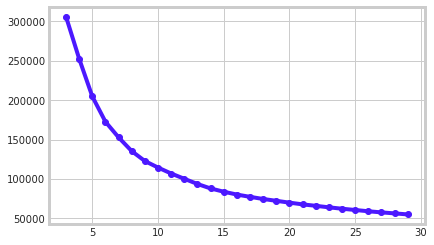

In [800]:
dist = [model.inertia_ for model in models]
plt.plot(K, dist, marker='o', color=config.color)